In [19]:
import os
import re
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import csv
import nltk
from nltk.tokenize import RegexpTokenizer
nltk.download('popular', quiet=True)
%matplotlib inline

In [2]:
import torch
device = torch.device("cpu")

In [3]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 46.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 73.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.8/199.8 KB 21.1 MB/s eta 0:00:00


In [4]:
from transformers import AutoTokenizer, AutoModel

In [5]:
tokenizer = AutoTokenizer.from_pretrained("asafaya/bert-mini-arabic")

<a id="2.1.1"> </a>
##### Preprocessing

In [34]:
# Define preprocessing util function
def text_preprocessing(document):
  # Remove URLs
  document = re.sub('(https|http).+', '', document)

  # Remove mentions and hashtags
  document = re.sub('[@#]\w+', '', document)

  # Remove english characters
  document = re.sub(r'\s*[A-Za-z]+\b', '' , document)

  # Replacing the multiple spaces between words with 1 space
  document = re.sub(' +', ' ', document)


  return document

In [35]:
text_preprocessing('مرحبا كيفك Te 88 😣')

'مرحبا كيفك 88 😣'

In [36]:
!pip install emoji

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [37]:
# Create a function to tokenize a set of texts
import emoji
import unicodedata
def preprocessing_for_bert(data, version="mini", text_preprocessing_fn = text_preprocessing ):
    """Perform required preprocessing steps for pretrained BERT.
    @param    data (np.array): Array of texts to be processed.
    @return   input_ids (torch.Tensor): Tensor of token ids to be fed to a model.
    @return   attention_masks (torch.Tensor): Tensor of indices specifying which
                  tokens should be attended to by the model.
    """
    # Create empty lists to store outputs
    input_ids = []
    attention_masks = []
    tokenizer = AutoTokenizer.from_pretrained("asafaya/bert-mini-arabic") if version == "mini" else AutoTokenizer.from_pretrained("asafaya/bert-base-arabic")

    # For every sentence...
    for i,sent in enumerate(data):
        # `encode_plus` will:
        #    (1) Tokenize the sentence
        #    (2) Add the `[CLS]` and `[SEP]` token to the start and end
        #    (3) Truncate/Pad sentence to max length
        #    (4) Map tokens to their IDs
        #    (5) Create attention mask
        #    (6) Return a dictionary of outputs
        encoded_sent = tokenizer.encode_plus(
            text=text_preprocessing_fn(sent),  # Preprocess sentence
            add_special_tokens=True,        # Add `[CLS]` and `[SEP]`
            max_length=MAX_LEN,                  # Max length to truncate/pad
            padding='max_length',        # Pad sentence to max length
            #return_tensors='pt',           # Return PyTorch tensor
            return_attention_mask=True,     # Return attention mask
            truncation = True 
            )
        
        # Add the outputs to the lists
        input_ids.append(encoded_sent.get('input_ids'))
        attention_masks.append(encoded_sent.get('attention_mask'))
    # Convert lists to tensors
    input_ids = torch.tensor(input_ids)
    attention_masks = torch.tensor(attention_masks)

    return input_ids, attention_masks

In [38]:
train = pd.read_csv('/content/OSACT2022-sharedTask-train.txt', sep='\t', header=None)
train.columns = ['drop1', 'text', 'drop2', 'label', 'drop3', 'drop4']
train.drop(['drop1', 'drop2', 'drop3', 'drop4'], axis=1, inplace=True)
train['label'].replace('NOT_HS', 0, inplace=True)
train['label'].replace('HS1', 1, inplace=True)
train['label'].replace('HS2', 1, inplace=True)
train['label'].replace('HS3', 1, inplace=True)
train['label'].replace('HS4', 1, inplace=True)
train['label'].replace('HS5', 1, inplace=True)
train['label'].replace('HS6', 1, inplace=True)

print(train['label'].value_counts())
train

0    7634
1     923
Name: label, dtype: int64


,text,label
0,@USER ردينا ع التطنز 😏👊🏻,0
1,وصارت فطاير البقالات غذاء صحي 👎🏻 URL,0
2,@USER روحي لبريده تلقين اشباه كثير بس ماحد زيك...,0
3,@USER مش باين حاجه خالص 😣<LF>مش عارف بقى 😔,0
4,#اليوم_الاثنين<LF><LF>👏 يقولك :%90 من المسلمي...,0
...,...,...
8552,@USER الله يلعنهم 🤢,0
8553,واحد سال زوجته بعد كم سنة زواج:<LF>- حبيبتي كم...,0
8554,@USER يالله روح زي الشاطر واحذف الشو الي سويته...,0
8555,لـمـا الـكـلاب تـهـوهـو عـلـيـك🐶🐶 وأنـت_اللـى_...,0


In [39]:
from sklearn.model_selection import train_test_split

X = train.text.values
y = train.label.values
X_train, X_val, y_train, y_val = train_test_split(X,y,test_size=0.1, random_state=2023)

In [40]:
# Specify `MAX_LEN`
MAX_LEN =  280

# Print sentence 0 and its encoded token ids
token_ids = list(preprocessing_for_bert([X[0]])[0].squeeze().numpy())
print('Original: ', X[0])
print('Token IDs: ', token_ids)

# Run function `preprocessing_for_bert` on the train set and the validation set
print('Tokenizing data...')
train_inputs, train_masks = preprocessing_for_bert(X_train)
val_inputs, val_masks = preprocessing_for_bert(X_val)

Original:  @USER ردينا ع التطنز 😏👊🏻
Token IDs:  [2, 3147, 2230, 241, 3115, 7983, 1, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Tokenizing data...


<a id="2.1.2"> </a>
##### Create data loaders for test and validation sets

In [43]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

# Convert other data types to torch.Tensor
train_labels = torch.tensor(y_train)
val_labels = torch.tensor(y_val)

# For fine-tuning BERT, the authors recommend a batch size of 16 or 32.
batch_size = 16

# Create the DataLoader for our training set
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Create the DataLoader for our validation set
val_data = TensorDataset(val_inputs, val_masks, val_labels)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

<a id="2.1.3"> </a>
##### Define model initialization class and functions

In [44]:
%%time
import torch
import torch.nn as nn
from transformers import BertModel

# Create the BertClassfier class
class BertClassifier(nn.Module):
    """Bert Model for Classification Tasks.
    """
    def __init__(self, freeze_bert=False, version="mini"):
        """
        @param    bert: a BertModel object
        @param    classifier: a torch.nn.Module classifier
        @param    freeze_bert (bool): Set `False` to fine-tune the BERT model
        """
        super(BertClassifier, self).__init__()
        # Specify hidden size of BERT, hidden size of our classifier, and number of labels
        D_in = 256 if version == "mini" else 768
        H, D_out = 50, 2

        # Instantiate BERT model
        self.bert = AutoModel.from_pretrained("asafaya/bert-mini-arabic") if version == "mini" else AutoModel.from_pretrained("asafaya/bert-base-arabic")
        # Instantiate an one-layer feed-forward classifier
        self.classifier = nn.Sequential(
            nn.Linear(D_in, H),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(H, D_out)
        )

        # Freeze the BERT model
        if freeze_bert:
            for param in self.bert.parameters():
                param.requires_grad = False
        
    def forward(self, input_ids, attention_mask):
        """
        Feed input to BERT and the classifier to compute logits.
        @param    input_ids (torch.Tensor): an input tensor with shape (batch_size,
                      max_length)
        @param    attention_mask (torch.Tensor): a tensor that hold attention mask
                      information with shape (batch_size, max_length)
        @return   logits (torch.Tensor): an output tensor with shape (batch_size,
                      num_labels)
        """
        # Feed input to BERT
        outputs = self.bert(input_ids=input_ids,
                            attention_mask=attention_mask)
        
        # Extract the last hidden state of the token `[CLS]` for classification task
        last_hidden_state_cls = outputs[0][:, 0, :]

        # Feed input to classifier to compute logits
        logits = self.classifier(last_hidden_state_cls)

        return logits

CPU times: user 76.5 ms, sys: 2.77 ms, total: 79.2 ms
Wall time: 178 ms


In [45]:
from transformers import AdamW, get_linear_schedule_with_warmup

from torch.optim import SparseAdam, Adam
def initialize_model(epochs=4, version="mini"):
    """Initialize the Bert Classifier, the optimizer and the learning rate scheduler.
    """
    # Instantiate Bert Classifier
    bert_classifier = BertClassifier(freeze_bert=False, version=version)
    # Tell PyTorch to run the model on GPU
    bert_classifier.to(device)

    # Create the optimizer
    optimizer = AdamW(params=list(bert_classifier.parameters()),
                      lr=5e-5,    # Default learning rate
                      eps=1e-8    # Default epsilon value
                      )

    # Total number of training steps
    total_steps = len(train_dataloader) * epochs

    # Set up the learning rate scheduler
    scheduler = get_linear_schedule_with_warmup(optimizer,
                                                num_warmup_steps=0, # Default value
                                                num_training_steps=total_steps)
    return bert_classifier, optimizer, scheduler

<a id="2.1.4"> </a>
##### Define model train and evaluate functions

In [46]:
import random
import time
import torch
import torch.nn as nn
# Specify loss function
loss_fn = nn.CrossEntropyLoss()

def set_seed(seed_value=42):
    """Set seed for reproducibility.
    """
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)

def train(model, train_dataloader, val_dataloader=None, epochs=4, evaluation=False):
    """Train the BertClassifier model.
    """
    # Start training loop
    print("Start training...\n")
    for epoch_i in range(epochs):
        # =======================================
        #               Training
        # =======================================
        # Print the header of the result table
        print(f"{'Epoch':^7} | {'Batch':^7} | {'Train Loss':^12} | {'Val Loss':^10} | {'Val Acc':^9} | {'Elapsed':^9}")
        print("-"*70)

        # Measure the elapsed time of each epoch
        t0_epoch, t0_batch = time.time(), time.time()

        # Reset tracking variables at the beginning of each epoch
        total_loss, batch_loss, batch_counts = 0, 0, 0

        # Put the model into the training mode
        model.train()

        # For each batch of training data...
        for step, batch in enumerate(train_dataloader):
            batch_counts +=1
            # Load batch to GPU
            b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)

            # Zero out any previously calculated gradients
            model.zero_grad()

            # Perform a forward pass. This will return logits.
            logits = model(b_input_ids, b_attn_mask)

            # Compute loss and accumulate the loss values
            loss = loss_fn(logits, b_labels)
            batch_loss += loss.item()
            total_loss += loss.item()

            # Perform a backward pass to calculate gradients
            loss.backward()

            # Clip the norm of the gradients to 1.0 to prevent "exploding gradients"
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            # Update parameters and the learning rate
            optimizer.step()
            scheduler.step()

            # Print the loss values and time elapsed for every 20 batches
            if (step % 20 == 0 and step != 0) or (step == len(train_dataloader) - 1):
                # Calculate time elapsed for 20 batches
                time_elapsed = time.time() - t0_batch

                # Print training results
                print(f"{epoch_i + 1:^7} | {step:^7} | {batch_loss / batch_counts:^12.6f} | {'-':^10} | {'-':^9} | {time_elapsed:^9.2f}")

                # Reset batch tracking variables
                batch_loss, batch_counts = 0, 0
                t0_batch = time.time()

        # Calculate the average loss over the entire training data
        avg_train_loss = total_loss / len(train_dataloader)

        print("-"*70)
        # =======================================
        #               Evaluation
        # =======================================
        if evaluation == True:
            # After the completion of each training epoch, measure the model's performance
            # on our validation set.
            val_loss, val_accuracy = evaluate(model, val_dataloader)

            # Print performance over the entire training data
            time_elapsed = time.time() - t0_epoch
            
            print(f"{epoch_i + 1:^7} | {'-':^7} | {avg_train_loss:^12.6f} | {val_loss:^10.6f} | {val_accuracy:^9.2f} | {time_elapsed:^9.2f}")
            print("-"*70)
        print("\n")
    
    print("Training complete!")


def evaluate(model, val_dataloader):
    """After the completion of each training epoch, measure the model's performance
    on our validation set.
    """
    # Put the model into the evaluation mode. The dropout layers are disabled during
    # the test time.
    model.eval()

    # Tracking variables
    val_accuracy = []
    val_loss = []

    # For each batch in our validation set...
    for batch in val_dataloader:
        # Load batch to GPU
        b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)

        # Compute logits
        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)

        # Compute loss
        loss = loss_fn(logits, b_labels)
        val_loss.append(loss.item())

        # Get the predictions
        preds = torch.argmax(logits, dim=1).flatten()

        # Calculate the accuracy rate
        accuracy = (preds == b_labels).cpu().numpy().mean() * 100
        val_accuracy.append(accuracy)

    # Compute the average accuracy and loss over the validation set.
    val_loss = np.mean(val_loss)
    val_accuracy = np.mean(val_accuracy)

    return val_loss, val_accuracy

<a id="2.1.5"> </a>
##### Initialize and train model

In [47]:
set_seed(42) 
bert_classifier, optimizer, scheduler = initialize_model(epochs=2)
train(bert_classifier, train_dataloader, val_dataloader, epochs=2, evaluation=True)

Some weights of the model checkpoint at asafaya/bert-mini-arabic were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use 

Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   1    |   20    |   0.469152   |     -      |     -     |   52.01  
   1    |   40    |   0.376765   |     -      |     -     |   47.28  
   1    |   60    |   0.339652   |     -      |     -     |   45.08  
   1    |   80    |   0.337558   |     -      |     -     |   49.70  
   1    |   100   |   0.266024   |     -      |     -     |   48.73  
   1    |   120   |   0.278296   |     -      |     -     |   50.05  
   1    |   140   |   0.327275   |     -      |     -     |   46.77  
   1    |   160   |   0.345153   |     -      |     -     |   44.33  
   1    |   180   |   0.263325   |     -      |     -     |   45.37  
   1    |   200   |   0.272255   |     -      |     -     |   46.02  
   1    |   220   |   0.341428   |     -      |     -     |   44.90  
   1    |   240   |   0.317408   |     -      |     -     |   47.28  


<a id="2.1.6"> </a>
##### Save model

In [48]:
# Saving the model for future runs

import pickle
filename = 'trained_model_mini_with_emojis_ALL_LABELS.sav'
pickle.dump(bert_classifier, open(filename, 'wb'))

In [ ]:
# import pickle
# filename = 'trained_model_mini_with_emojis.sav'
# f = open(filename, 'rb')
# bert_classifier = pickle.load(f)

In [49]:
with open('/content/OSACT2022-sharedTask-test-taskB-gold-labels.txt') as f:
  taskB = f.readlines()
print(len(taskB))
print(dict((x,taskB.count(x)) for x in set(taskB)))
print('')

with open('/content/OSACT2022-sharedTask-test-taskC-gold-labels.txt') as f:
  taskC = f.readlines()
print(len(taskC))
print(dict((x,taskC.count(x)) for x in set(taskC)))

2541
{'NOT_HS\n': 2270, 'HS\n': 271}

2541
{'HS6\n': 133, 'HS5\n': 19, 'HS1\n': 78, 'HS3\n': 32, 'NOT_HS\n': 2270, 'HS2\n': 7, 'HS4\n': 2}


In [50]:
test = pd.read_csv('/content/OSACT2022-sharedTask-test-tweets.txt', sep='\t', header=None)
test.columns = ['drop', 'text']
test.drop('drop', axis=1, inplace=True)
test['label'] = taskB
test['label'].replace('NOT_HS\n', 'NOT_HS', inplace=True)
test['label'].replace('HS\n', 'HS', inplace=True)
test['label'].replace('NOT_HS', 0, inplace=True)
test['label'].replace('HS', 1, inplace=True)
print(test['label'].value_counts())
X_test = test.text.values
y_test = test.label.values
test

0    2270
1     271
Name: label, dtype: int64


,text,label
0,@USER هتهزر معايا ولا ايه 😡😡😡😡,0
1,مشفتش العرض بتاعهم لا مش مهتمة لا😩🐸😂 URL,0
2,RT @USER عندما تكون لوحدك تحس انك لحالك صح 😊<L...,0
3,RT @USER ماشاء الله الرجال باين عليه محترم <LF...,0
4,@USER شسالفة احد يفهمني 😤,0
...,...,...
2536,قله حيا وين اهلهم ذولي الله لايبلانا لهالدرجه ...,0
2537,RT @USER ثم الطحلبه🐸🐸🐸 URL,0
2538,يا وجه الله 😷 من اليوم ورايح شاورما انسى 🔪 URL,0
2539,@USER متخلف حتى الحلال حرمتوه 😷,0


<a id="2.1.7"> </a>
##### Define prediction and test set evaluation functions

In [51]:
import torch.nn.functional as F

def bert_predict(model, test_dataloader):
    """Perform a forward pass on the trained BERT model to predict probabilities
    on the test set.
    """
    # Put the model into the evaluation mode. The dropout layers are disabled during
    # the test time.
    model.eval()

    all_logits = []

    # For each batch in our test set...
    for batch in test_dataloader:
        # Load batch to GPU
        b_input_ids, b_attn_mask = tuple(t.to(device) for t in batch)[:2]

        # Compute logits
        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)
        all_logits.append(logits)
    
    # Concatenate logits from each batch
    all_logits = torch.cat(all_logits, dim=0)

    # Apply softmax to calculate probabilities
    probs = F.softmax(all_logits, dim=1).cpu().numpy()

    return probs

In [52]:
from sklearn.metrics import accuracy_score, roc_curve, auc

def evaluate_roc(probs, y_true, model_name, dataset_name, test_dataset_name):
    """
    - Print AUC and accuracy on the test set
    - Plot ROC
    @params    probs (np.array): an array of predicted probabilities with shape (len(y_true), 2)
    @params    y_true (np.array): an array of the true values with shape (len(y_true),)
    """
    preds = probs[:, 1]
    fpr, tpr, threshold = roc_curve(y_true, preds)
    roc_auc = auc(fpr, tpr)
    print(f'AUC: {roc_auc:.4f}')
       
    # Get accuracy over the test set
    y_pred = np.where(preds >= 0.5, 1, 0)
    accuracy = accuracy_score(y_true, y_pred)
    print(f'Accuracy: {accuracy*100:.2f}%')
    
    # Plot ROC AUC
    plt.title(f" ROC of {model_name}  trained on {dataset_name} dataset & evaluated on the {test_dataset_name} dataset ")
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

<a id="2.1.8"> </a>
##### Predict and evaluate validation subset

AUC: 0.9229
Accuracy: 90.89%


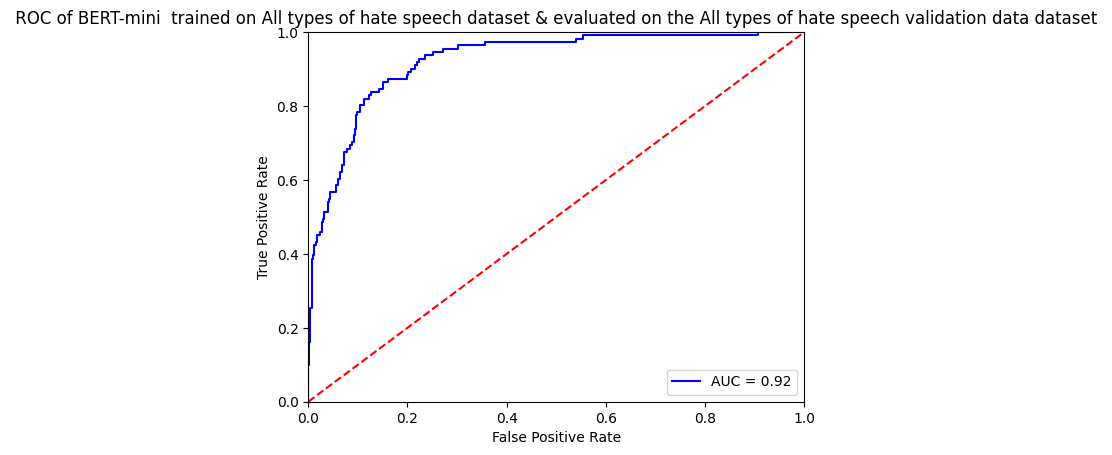

In [53]:
# Compute predicted probabilities on the validation set
probs = bert_predict(bert_classifier, val_dataloader)

# Evaluate the Bert classifier
evaluate_roc(probs, y_val, "BERT-mini", "All types of hate speech", "All types of hate speech validation data")

<a id="2.1.9"> </a>
##### Predict and evaluate test subset

In [54]:
# Run `preprocessing_for_bert` on the test set
print('Tokenizing data...')
test_inputs, test_masks = preprocessing_for_bert(X_test)

# Create the DataLoader for our test set
test_dataset = TensorDataset(test_inputs, test_masks)
test_sampler = SequentialSampler(test_dataset)
test_dataloader = DataLoader(test_dataset, sampler=test_sampler, batch_size=32)

Tokenizing data...


In [55]:
# Compute predicted probabilities on the test set
probs = bert_predict(bert_classifier, test_dataloader)

# Get predictions from the probabilities
threshold = 0.5
preds = np.where(probs[:, 1] > threshold, 1, 0)

# Number of tweets predicted hate speech
print("hate speech tweets ratio ", preds.sum()/len(preds))

hate speech tweets ratio  0.08736717827626919


AUC: 0.9020
Accuracy: 91.62%


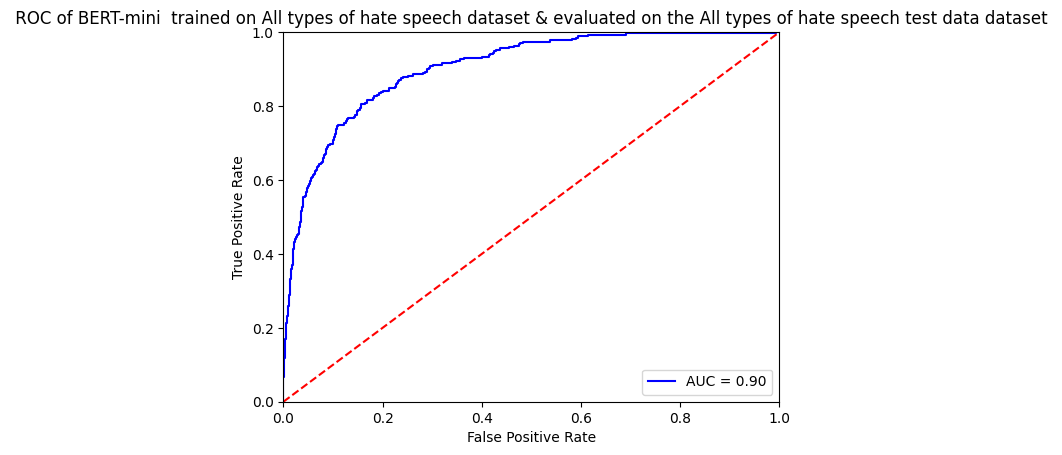

In [56]:
# Evaluate the Bert classifier for unseen test data
evaluate_roc(probs, y_test,"BERT-mini", "All types of hate speech", "All types of hate speech test data")

<a id="2.2"> </a>
### BERT-mini without emojis

<a id="2.2.1"> </a>
##### Define modified preprocessing function

In [57]:
def remove_emojis(sent):
    text =  emoji.demojize(sent)
    text= re.sub(r'(:[!_\-\w]+:)', '', text)
    return text

In [58]:
# Redefine the text_processing function to include the remove emojis step
def text_preprocessing_no_emojis(text):
    """
    - Remove entity mentions (eg. '@united')
    - Correct errors (eg. '&amp;' to '&')
    @param    text (str): a string to be processed.
    @return   text (Str): the processed string.
    """
  
    # Remove emojis
    text = remove_emojis(text)

    return text_preprocessing(text)

<a id="2.2.2"> </a>
##### Preprocess and create data loaders

In [59]:
# Specify `MAX_LEN`
MAX_LEN =  280

# Print sentence 0 and its encoded token ids
token_ids = list(preprocessing_for_bert([X[0]], text_preprocessing_fn=text_preprocessing_no_emojis)[0].squeeze().numpy())
print('Original: ', X[0])
print('Token IDs: ', token_ids)

# Run function `preprocessing_for_bert` on the train set and the validation set
print('Tokenizing data...')
train_inputs, train_masks = preprocessing_for_bert(X_train, text_preprocessing_fn=text_preprocessing_no_emojis)
val_inputs, val_masks = preprocessing_for_bert(X_val, text_preprocessing_fn=text_preprocessing_no_emojis)
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

# Convert other data types to torch.Tensor
train_labels = torch.tensor(y_train)
val_labels = torch.tensor(y_val)

# For fine-tuning BERT, the authors recommend a batch size of 16 or 32.
batch_size = 16

# Create the DataLoader for our training set
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Create the DataLoader for our validation set
val_data = TensorDataset(val_inputs, val_masks, val_labels)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

Original:  @USER ردينا ع التطنز 😏👊🏻
Token IDs:  [2, 3147, 2230, 241, 3115, 7983, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Tokenizing data...


<a id="2.2.3"> </a>
##### Train

In [60]:
set_seed(42) 
bert_classifier, optimizer, scheduler = initialize_model(epochs=2)
train(bert_classifier, train_dataloader, val_dataloader, epochs=2, evaluation=True)

Some weights of the model checkpoint at asafaya/bert-mini-arabic were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use 

Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   1    |   20    |   0.473442   |     -      |     -     |   63.54  
   1    |   40    |   0.370727   |     -      |     -     |   49.90  
   1    |   60    |   0.340153   |     -      |     -     |   48.56  
   1    |   80    |   0.339729   |     -      |     -     |   49.51  
   1    |   100   |   0.263531   |     -      |     -     |   47.42  
   1    |   120   |   0.276918   |     -      |     -     |   50.42  
   1    |   140   |   0.342051   |     -      |     -     |   49.46  
   1    |   160   |   0.346121   |     -      |     -     |   50.07  
   1    |   180   |   0.269610   |     -      |     -     |   48.38  
   1    |   200   |   0.265052   |     -      |     -     |   50.17  
   1    |   220   |   0.334397   |     -      |     -     |   48.87  
   1    |   240   |   0.300554   |     -      |     -     |   50.32  


<a id="2.2.4"> </a>
##### Evaluate on test datasets

In [61]:
# Evaluate the performance of a model on test datasets
def evaluate_dataset(sents, labels, model_name, dataset_name, test_dataset_name):
    test_inputs, test_masks = preprocessing_for_bert(sents)

    # Create the DataLoader for our test set
    test_dataset = TensorDataset(test_inputs, test_masks)
    test_sampler = SequentialSampler(test_dataset)
    test_dataloader = DataLoader(test_dataset, sampler=test_sampler, batch_size=32)
    # Compute predicted probabilities on the test set
    probs = bert_predict(bert_classifier, test_dataloader)

    # Get predictions from the probabilities
    threshold = 0.5
    preds = np.where(probs[:, 1] > threshold, 1, 0)
    auc_graph = evaluate_roc(probs, labels, model_name, dataset_name, test_dataset_name )

    return auc_graph

AUC: 0.9013
Accuracy: 91.66%


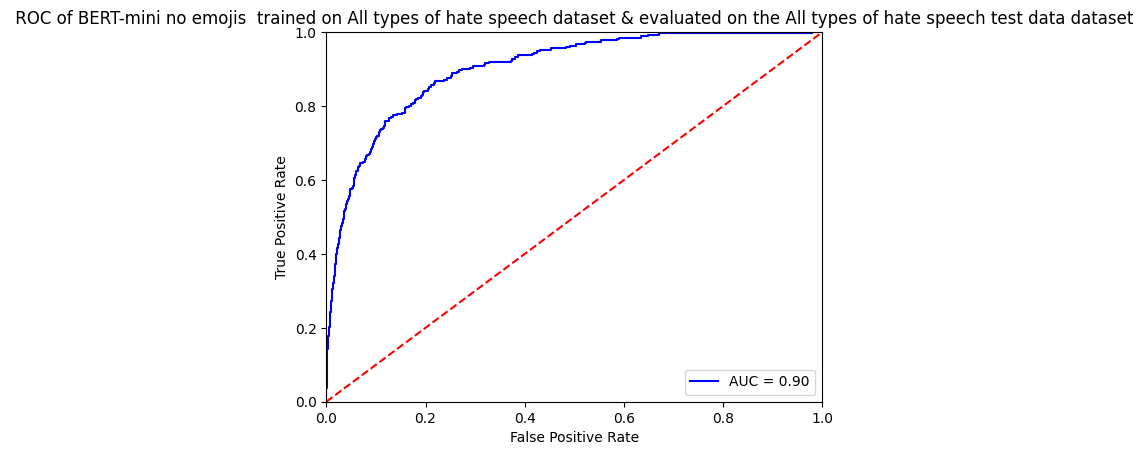

In [62]:
# Evaluate on the unseen test data
evaluate_dataset(X_test, y_test,"BERT-mini no emojis", "All types of hate speech", "All types of hate speech test data")